In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

# SupCon ImageWang Tutorial

**Note:** This notebook demonstrates how to use `SupCon` callback with a single GPU. For distributed version, `DistributedSupCon` checkout documentation.

First import **fastai** for training and other helpers, you can choose not to use **wandb** by setting `WANDB=False`.

In [4]:
from fastai.vision.all import *
torch.backends.cudnn.benchmark = True
WANDB = True
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

Then import **self_supervised** `augmentations` module for creating augmentations pipeline, `layers` module for creating encoder and model, and finally `simclr` for self-supervised training.

In [5]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.supcon import *
from self_supervised.vision.metrics import *
import timm

In this notebook we will take a look at [ImageWang](https://github.com/fastai/imagenette#image%E7%BD%91) benchmark, how to train a self-supervised model using MoCo algorithm and then how to use this pretrained model for finetuning on the given downstream task. 

## Pretraining

In [6]:
def get_dls(size, bs, n_per_class=30, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['unsup', 'train'])

    
    labels = [o.parent.name for i,o in enumerate(files)]
    split_df = pd.DataFrame(labels, columns=['label']).reset_index()
    valid_idxs = split_df.query("label != 'unsup'").groupby("label").sample(n_per_class)['index'].values
    split_df['is_valid'] = False
    split_df.loc[split_df['index'].isin(valid_idxs), 'is_valid'] = True
    train_idxs = split_df[~split_df.is_valid]['index'].values
    valid_idxs = split_df[split_df.is_valid]['index'].values

    
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    dsets = Datasets(files, tfms=tfms, splits=[train_idxs, valid_idxs])
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

ImageWang has several benchmarks for different image sizes, in this tutorial we will go for `size=224` and also demonstrate how effectively you can utilize GPU memory.

Define batch size, resize resolution before batching and size for random cropping during self-supervised training. It's always good to use a batch size as high as it can fit the GPU memory.

In [7]:
bs, resize, size = 320, 256, 224

Select architecture to train on, remember all **timm** and **fastai** models are available! We need to set `pretrained=False` here because using imagenet weights for ImageWang data would be cheating.

In [8]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

# arch = "resnet34d"
# encoder = CheckpointResNet(create_encoder(arch, pretrained=False, n_in=3), checkpoint_nchunks=2)

In [9]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SupCon"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)


Initialize the Dataloaders using the function above.

In [7]:
dls = get_dls(resize, bs)

Create SupCon model. You can change values of `hidden_size`, `projection_size`, and `n_layers`. For this problem, defaults work just fine so we don't do any changes.

In [8]:
model = create_supcon_model(encoder)

Next step is perhaps the most critical step for achieving good results on a custom problem - data augmentation. For this, we will use utility function from `self_supervised.vision.supcon.get_simclr_aug_pipelines` but you can also use your own list of Pipeline augmentations. `self_supervised.vision.supcon.get_moco_aug_pipelines`should be enough for most of the cases since under the hood it uses `self_supervised.augmentations.get_multi_aug_pipelines` and `self_supervised.augmentations.get_batch_augs`. You can do shift+tab and see all the arguments that can be passed to `get_supcon_aug_pipelines`. You can simply pass anything that you could pass to `get_batch_augs` including custom `xtra_tfms`.

`get_supcon_aug_pipelines` excepts size for random resized cropping of the 2 views of a given image and the rest of the arguments are coming from `get_batch_augs()`

In [9]:
aug_pipelines = get_supcon_aug_pipelines(size, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

Here, we will feed the augmentation pipelines and leave temperature parameter as default.

In [10]:
cbs=[SupCon(aug_pipelines, 
            unsup_class_id = dls.vocab.o2i['unsup'], 
            unsup_method = UnsupMethod.All, 
            reg_lambda = 1.0, 
            temp = 0.07)]
if WANDB: cbs += [WandbCallback(log_preds=False, log_model=False)]

In [11]:
knn_metric_cb = KNNProxyMetric()
cbs += [knn_metric_cb]
metric = ValueMetric(knn_metric_cb.accuracy, metric_name='knn_accuracy')

In [12]:
learn = Learner(dls, model, opt_func=Lamb, cbs=cbs, metrics=metric)

Before starting training let's check whether our augmentations makes sense or not. Since this step consumes GPU memory, once you are done with inspection, restart the notebook and skip this step. We can see that 2 views of the same image side by side and indeed augmentations look pretty good. Now, it's time restart the notebook and skip this step.

In [13]:
# b = dls.one_batch()
# learn._split(b)
# learn('before_batch')
# learn.sup_con.show(n=5);

Use mixed precision with `to_fp16()` for more GPU memory, larger batch size and faster training . We could also use gradient checkpointing wrapper models from `self_supervised.layers` to save even more memory, e.g. `CheckpointSequential()`.

In [14]:
learn.to_fp16();

Learning good representations via contrastive learning usually takes a lot of epochs. So here number epochs are set to 100. This might change depending on your data distribution and dataset size.

In [15]:
lr,wd,epochs=1e-3,1e-4,100

In [16]:
learn.unfreeze()

In [17]:
# learn.lr_find()

In [18]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,knn_accuracy,time
0,11.077615,11.246819,0.135000,01:07
1,10.545448,11.224407,0.145000,01:04
2,10.207901,11.103373,0.135000,01:04
3,9.923880,10.912027,0.138333,01:03
4,9.464316,9.780476,0.130000,01:05
5,9.210593,10.225823,0.163333,01:04
6,9.134113,9.294271,0.176667,01:09


KeyboardInterrupt: 

In [43]:
if WANDB: wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
knn_accuracy,▁▂▁▃▃▄▃▁▅▄▅▆▅▇▇▇▆▆▆▆▅█▅▇█▆▇▇
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▅▆▆▅▅▄▄▄▃▃▄▄▄▄▄▃▂▃▃▃▃▂▂▂▃▂▂▆▂▂▂▁▂▂▁▁▄▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,██▆▅▆▅▃▅▅▄▄▃▆▄▃▂▂▁▄▂▆▄▂▁▅▁▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,28.25


In [39]:
save_name = f'supcon_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
# torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')
torch.save(learn.model.encoder.resnet_model.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

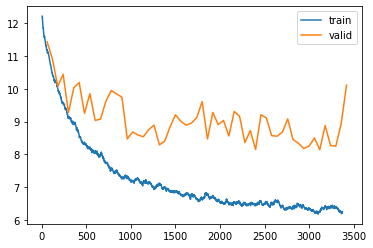

In [23]:
learn.recorder.plot_loss()

In [17]:
wandb.run.name

'bumbling-paper-72'

## Downstream Task

In [19]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [20]:
bs, size

(360, 224)

In [28]:
bs = 64

In [40]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [48]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier, Flatten())
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropyFlat())
    return learn

In [49]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [50]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='resnet34d', encoder_path=f'models/supcon_iwang_sz{size}_epc1_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.941808,3.543563,0.018580,0.346653,00:48
1,1.643975,3.216995,0.060575,0.461441,00:48
2,1.563258,2.808348,0.110461,0.682871,00:48
3,1.393904,2.813592,0.127259,0.634258,00:48
4,1.241389,2.502521,0.236701,0.757190,00:48


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


KeyboardInterrupt: 

In [ ]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

### 20 epochs

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 80 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)